Run `pip install .` first to install all dependencies.

In [ ]:
!pip install gcsfs==2022.10.0
!pip install wandb==0.13.4
#!pip install fastparquet
!pip install numpy
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
  Using cached gcsfs-2022.10.0-py2.py3-none-any.whl (25 kB)
  Using cached google_auth-2.15.0-py2.py3-none-any.whl (177 kB)
  Using cached google_auth_oauthlib-0.8.0-py2.py3-none-any.whl (19 kB)
  Using cached google_cloud_storage-2.7.0-py2.py3-none-any.whl (110 kB)
  Using cached fsspec-2022.10.0-py3-none-any.whl (138 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached cachetools-5.2.0-py3-none-any.whl (9.3 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached google_resumable_media-2.4.0-py2.py3-none-any.whl (77 kB)
  Using cached google_cloud_core-2.3.2-py2.py3-none-any.whl (29 kB)
  Using cached google_api_core-2.11.0-py3-none-any.whl (120 kB)
  Using cached googleapis_common_protos-1.57.0-py2.py3-none-any.whl (217 kB)
  Using cached protobuf-4.21.11-cp37-abi3-manylinux2014_x86_64.whl (409 kB)

In [ ]:
import gcsfs
import numpy as np
import pandas as pd

import wandb

from sklearn.preprocessing import MinMaxScaler


In [ ]:
name = "classical_size_features_accuracy_branch"

# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")

dataset = wandb.Artifact(name=name, type="preprocessed_data")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


In [ ]:
# import google.auth
# from google.colab import auth
# # connect to google cloud storage
# auth.authenticate_user()
# credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis")

/pfs/data5/home/kit/stud/uloak/thesis/thesis/lib64/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
# reduce number of imported cols due to memory issues
columns = [
    "QUOTE_DATETIME",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]


In [ ]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet",
    engine="fastparquet",
    columns=columns,
)
val = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet",
    engine="fastparquet",
    columns=columns,
)

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
# oe_option_type = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )
# oe_root = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )
# oe_issue_type = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )

#min_max_scaler = MinMaxScaler(feature_range=[-1, 1])
scaler = RobustScaler()

def transform(data: pd.DataFrame) -> pd.DataFrame:

    # # date features
    x = pd.DataFrame(data={"TRADE_PRICE": data["TRADE_PRICE"]}, index=data.index)

    # x["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
    # x["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

    # seconds_in_day = 24 * 60 * 60
    # seconds = (
    #     data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()
    # ).dt.total_seconds()

    # x["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
    # x["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

    # option features
    # x["ttm"] = (
    #     data["EXPIRATION"].dt.to_period("M") - data["QUOTE_DATETIME"].dt.to_period("M")
    # ).apply(lambda x: x.n)
    # x[["myn", "day_vol"]] = data[["myn", "day_vol"]]
    # x["log_strk_prc"] = np.log1p(data["STRK_PRC"])

    # binarize
    # "bin_OPTION_TYPE", "bin_issue_type", "bin_ROOT",

    # size features
    x["bid_ask_size_ratio_ex"] = data["bid_size_ex"] / data["ask_size_ex"]
    x["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
    x["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]
     
    
    # classical
    mid_ex = 0.5 * (data["ask_ex"] + data["bid_ex"])
    mid_best = 0.5 * (data["BEST_ASK"] + data["BEST_BID"])
    x["rel_ask_ex"] = (data["TRADE_PRICE"] - mid_ex) / (data["ask_ex"] - mid_ex)
    x["rel_bid_ex"] = (mid_ex - data["TRADE_PRICE"]) / (mid_ex - data["bid_ex"])
    x["BEST_rel_bid"] = (data["TRADE_PRICE"] - mid_best) / (data["BEST_ASK"] - mid_best)
    x["BEST_rel_ask"] = (mid_best - data["TRADE_PRICE"]) / (mid_best - data["BEST_BID"])

    # some uncovered comparsions
    # x["ask_ex_best_ratio"] = data["ask_ex"] / data["BEST_ASK"]
    # x["bid_ex_best_ratio"] = data["bid_ex"] / data["BEST_BID"]
    # x["mid_ex_best_ratio"] = mid_ex / mid_best
    x["ask_ex_best_ratio"] = data["ask_ex"]  / data["BEST_ASK"]
    x["bid_ex_best_ratio"] = data["bid_ex"]  / data["BEST_BID"]
    x["mid_ex_best_ratio"] = mid_ex  / mid_best
    
    x["bid_ask_ratio_ex"] = data["bid_ex"] / data["ask_ex"]
    # x["price_norm_size"] = data["TRADE_PRICE"] / data["TRADE_SIZE"]
    x["price_rel_nbb"] = (data["BEST_ASK"] - data["TRADE_PRICE"]) / (data["BEST_ASK"] - mid_best)
    x["price_rel_nbo"] = (data["TRADE_PRICE"] - data["BEST_BID"]) / (mid_best - data["BEST_BID"])
    # x["price_eq_ask_eq_bid"] = (data["TRADE_PRICE"] == data["ask_ex"]) & (data["TRADE_PRICE"] == data["bid_ex"])
    
    # calculate log returns
    x["chg_ex_lead"] = data["TRADE_PRICE"] - data["price_ex_lead"]
    x["chg_ex_lag"] = data["TRADE_PRICE"] - data["price_ex_lag"]
    x["chg_all_lead"] = data["TRADE_PRICE"] - data["price_all_lead"]
    x["chg_all_lag"] = data["TRADE_PRICE"] - data["price_all_lag"]

    # log transformed features
    x[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex",
         ]
     ] = data[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex"
         ]
     ]
    

    # impute with zeros
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    x.fillna(0, inplace=True)

    # scale to [-1, 1]
    if not hasattr(scaler, "n_features_in_"):
        scaler.fit(x)
    x[x.columns] = scaler.transform(x)

    # https://stackoverflow.com/questions/70727291/how-do-i-know-whether-a-sklearn-scaler-is-already-fitted-or-not

    # if not hasattr(oe_option_type, "n_features_in_"):
    #     oe_option_type.fit(data["OPTION_TYPE"].astype(str).values.reshape(-1, 1))
    # x["bin_option_type"] = oe_option_type.transform(
    #     data["OPTION_TYPE"].astype(str).values.reshape(-1, 1)
    # )

    # if not hasattr(oe_root, "n_features_in_"):
    #     oe_root.fit(data["ROOT"].astype(str).values.reshape(-1, 1))
    # x["bin_root"] = oe_root.transform(data["ROOT"].astype(str).values.reshape(-1, 1))

    # if not hasattr(oe_issue_type, "n_features_in_"):
    #     oe_issue_type.fit(data["issue_type"].astype(str).values.reshape(-1, 1))
    # x["bin_issue_type"] = oe_issue_type.transform(
    #     data["issue_type"].astype(str).values.reshape(-1, 1)
    # )

    # x.replace([np.inf, -np.inf], np.nan, inplace=True)

    x["buy_sell"] = data["buy_sell"]
    return x


In [ ]:
train = transform(train)

X_train = train.sample(frac=0.1)
y_train = X_train.buy_sell
X_train.drop(columns=["buy_sell"], inplace=True)

del train

In [ ]:
val = transform(val)

X_val = val.sample(frac=0.1)
y_val = X_val.buy_sell
X_val.drop(columns=["buy_sell"], inplace=True)

del val

In [ ]:
from catboost import CatBoostClassifier, Pool

## Visualize weights

In [2]:
import matplotlib.pyplot as plt
import numpy as np

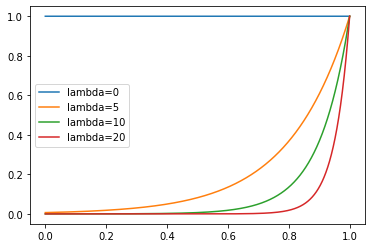

In [85]:
# the greater the more aggressive
lambdas = [0, 5, 10, 20]

for lam in lambdas:
  # https://en.wikipedia.org/wiki/Exponential_decay
  x = np.linspace(0,1, num=2000)
  y = np.exp(-lam * x)[::-1]
  plt.plot(x, y, label=f"lambda={lam}")
  plt.legend()

In [ ]:
params = {
        "od_type": "Iter",
        "logging_level": "Silent",
        "loss_function": "Logloss",
        "task_type": "GPU",
        "cat_features": None,
        "random_seed": 42,
        "eval_metric":"Accuracy",
        "iterations":5000,
        "early_stopping_rounds":100,
}

model = CatBoostClassifier(**params)
train_pool = Pool(X_train, y_train,weight = X_train.index.values)
model.fit(train_pool, eval_set=(X_val,y_val), plot=True)

print(model.score(X_val, y_val))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7434206176863968


In [ ]:
X_train.index

Int64Index([17918057, 15579515,  4006045, 21244996, 12212835,  5428674,
            13000880, 27109426, 13201713, 17462890,
            ...
              563335, 22405423, 24133352,  5975351, 10373656,  1418921,
            14490405, 17674067, 15527286,  9434775],
           dtype='int64', length=2951032)

In [ ]:
# 0.7333797810178145 (logs applied) to     x["bid_ask_size_ratio_ex"] x["rel_bid_size_ex"]   x["rel_ask_size_ex"] 
# 0.7331946683482763 (all from above + log returns)
# 0.734859665271541 (all above + compare mids, ask, and bid at exchange with nation wide)
# 0.7349013664773161 (all above + trade_price == bid_ex == ask_ex)
# 0.7351464881990674 (price normed size)
# 0.7352807457396116 (all above +  x["price_rel_nbo"] +  x["price_rel_nbb"])
# 0.74296292 (some removed, see above, max. iterations reached. Actually there is no reason to stop ensemble)
# 0.745053067 convert some ratios to percentages (all other things the same as above)
# robust scaler with log (ca. 74.4)
# robust scaler without log 0.74342061

In [ ]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance


,Feature Id,Importances
0,ask_size_ex,12.525492
1,bid_size_ex,11.546952
2,rel_ask_ex,10.194505
3,bid_ask_size_ratio_ex,8.590138
4,rel_bid_ex,7.966504
5,rel_bid_size_ex,5.996297
6,BEST_rel_ask,4.807563
7,rel_ask_size_ex,4.260232
8,price_rel_nbo,3.670372
9,bid_ask_ratio_ex,3.384097
